This notebook models classifiers to detect if a given county is a close result in the 2016 election (labeled "swing") or not (labeled "safe"). Interpretable models will be used to investigate which features indicate a battleground county. Models prioritize sensitivity (higher true positive rate) with recall score.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# pca
from sklearn import decomposition
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# model saver
from sklearn.externals import joblib

## other

In [3]:
# upsampling with SMOTE
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as imbPipeline

## Plot Settings

In [4]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=22) 
# axes label fontsize
plt.rc('axes', labelsize=18)
# axes values fontsize
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
# legend fontsize
plt.rc('legend', fontsize=16)

# Custom Functions

## Feature Weight Sorting

In [5]:
def feat_sort(values, labels, ret_num='all'):
    '''
    Return dataframe of sorted (by absolute value) feature weights
    values : feature weight values from analysis
    labels : names of each feature
    ret_num : number of top features to return
    '''
    
    df = pd.DataFrame(values, index=labels, columns=['feat_wgt'])
    # drop weights = 0
    df = df[df['feat_wgt'] != 0]
    # note which weights are positive
    df['positive'] = df['feat_wgt'] > 0
    # take absolute value of weights
    df['feat_wgt'] = df['feat_wgt'].apply(abs)
    # sort weights (largest to smalles)
    df.sort_values(by='feat_wgt', ascending=False, inplace=True)
    if ret_num == 'all':
        return(df)
    else:
        return(df.iloc[:ret_num, :])

## Space Log
Return range of numbers between two values in a log scale

In [6]:
def space_log(start, stop, number):
    return(np.exp(np.linspace(np.log(start), np.log(stop), number)))

# Data

In [7]:
df = pd.read_csv('data/county_data.csv', index_col=0)
df.head()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect
code,,,,,,,,,,,,,,
1001,55504.0,1.7,20800.0,37.8,39721.0,54487.0,3.9,13.5,87.6,24.6,93.371913,0.762305,0.025512,0
1003,212628.0,16.7,75149.0,42.3,41286.0,56460.0,4.0,11.7,90.0,29.5,133.746808,0.810999,0.040973,0
1005,25270.0,-8.0,9122.0,38.7,31788.0,32884.0,5.9,29.9,73.8,12.9,28.557545,0.491888,0.045390,0
1007,22668.0,-1.1,7048.0,40.2,29264.0,43079.0,4.4,20.1,80.7,12.0,36.409779,0.766278,0.022146,0
1009,58013.0,1.2,20619.0,40.8,31470.0,47213.0,4.0,14.1,80.0,13.0,89.973324,0.949322,0.086808,0


In [8]:
# drop nans
df.dropna(inplace=True);

## Dataframes

In [9]:
# initialize feature dataframe and observed outcome
X = df.iloc[:, 0:13]
y = df.iloc[:, 13]

## EDA

In [10]:
# sns.pairplot(df);

In [11]:
# inspect mean values of features for not-close vs close outcomes
df.groupby('close_elect').mean()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,97754.622861,0.673854,35383.793292,41.180151,40647.942847,49173.193018,4.611328,15.914203,85.657392,20.269884,251.164202,0.838362,0.088684
1,213686.159236,2.568153,77334.891720,38.888535,42207.388535,53773.019108,4.530573,15.549045,88.495541,27.620382,317.779807,0.760183,0.095176


In [12]:
close = (df['close_elect'] == 1).sum()
not_close = (df['close_elect'] == 0).sum()

In [13]:
# baseline, null model accuracy - guess '0' every time
(df['close_elect'] == 0).sum() / len(df)

0.9490094186424164

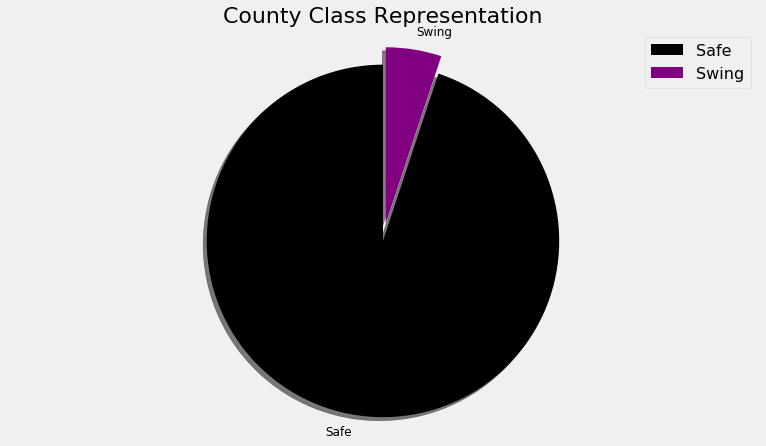

In [14]:
# plot pie chart

sizes = [not_close, close]
explode = (0, 0.1)
colors = ['black', 'purple']

fig, ax = plt.subplots()
ax.pie(sizes, labels=['Safe', 'Swing'], explode=explode, colors=colors,
        shadow=True, startangle=90)
ax.axis('equal') # circle shape
ax.set_title('County Class Representation')
ax.legend();
# plt.savefig('model_output/cls_rep.png')

**Notes**
- Data is extremely unbalanced  
- "Safe" counties are much more prevalent in data (about 95% of observations)
- A model could attain 95% accuracy by always predicting "safe" counties!

## Principle Component Analysis (PCA)
Reduce dimensionality of data to 2-D so that grouping trends can potentially be visualized

### Scaling

In [15]:
# scale data to have mean = 0 and variance = 1
scaler = preprocessing.StandardScaler()
X_scl = scaler.fit_transform(X)

In [16]:
# decomposition to 2-D
pca = decomposition.PCA(n_components=2)
pca_features = pca.fit_transform(X_scl)

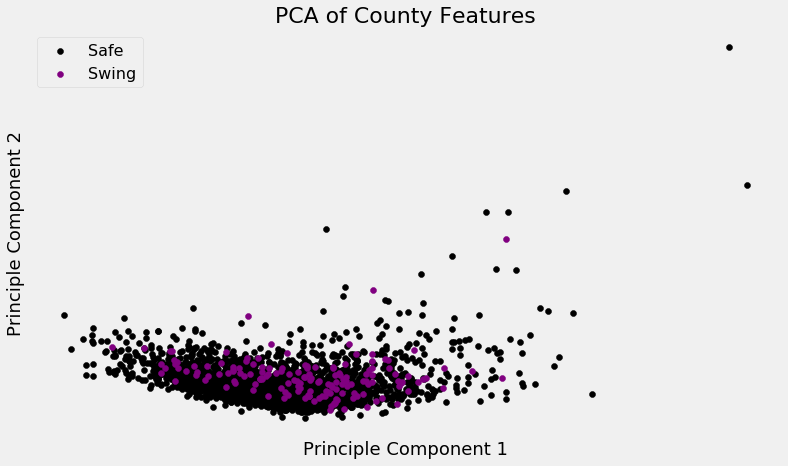

In [17]:
# plot components
class_labels = ['Safe', 'Swing']
colors = ['black', 'purple']

plt.figure()
for i, label in enumerate(class_labels):
    plt.scatter(pca_features[y == i, 0], pca_features[y == i, 1],
                label=label, c=colors[i])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('PCA of County Features')
plt.xticks([]) # component valuables not interpretable
plt.yticks([]) # component valuables not interpretable
plt.legend();
# plt.savefig('model_output/pca.png')

# Pre-processing

## Train/test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**Notes**  
Swing counties seem to have a grouping trend but are not noticeably separated from safe counties

# Logistic Regression Modeling

In [19]:
# dictionary to record model results
log_recalls = {}

## Initial Model

In [20]:
# model pipeline includes scaling
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())
])

In [21]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [22]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
metrics.confusion_matrix(y_test, log_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**
- model does not accurately predict any swing counties  
    - this is a result of the severe imbalance of classes in the dataset
- recall is to be prioritized
    - this will help the model capture more swing counties (label 1)
    - may result in more false positives and reduced overall accuracy

## Tuning with GridSearch
Tune model hyperparameter for optimal model performance

In [24]:
# try range of values for C and penalty hyperparameters
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}

In [25]:
# tune model pipeline for recall
log_tune = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')

In [26]:
log_tune.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__penalty': ['l1', 'l2'], 'model__C': array([1.00000e-03, 2.27585e-03, 5.17947e-03, 1.17877e-02, 2.68270e-02,
       6.10540e-02, 1.38950e-01, 3.16228e-01, 7.19686e-01, 1.63789e+00,
       3.72759e+00, 8.48343e+00, 1.93070e+01, 4.39397e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [27]:
# assign best hyperparameter values from tuning
best_penalty = log_tune.best_params_['model__penalty']
best_C = log_tune.best_params_['model__C']

In [28]:
# model pipeline with optimal hyperparameters
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty, C=best_C))
])

In [29]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [30]:
# record model recall results
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, log_pred)
log_recalls['initial'] = recall[1]

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
metrics.confusion_matrix(y_test, log_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**  
Tuning did not increase recall for swing counties

## Balanced Weights
Modifies "weights" of classes in algorithm's cost function to place greater importance on minority class  
Balanced weights are inversely proportional to the frequency of class observations

In [33]:
# model pipeline with class weights set to balanced
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced'))
])

In [34]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [35]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.98      0.77      0.86       729
          1       0.15      0.71      0.24        41

avg / total       0.93      0.77      0.83       770



In [36]:
metrics.confusion_matrix(y_test, log_pred)

array([[562, 167],
       [ 12,  29]])

**Notes**  
This greatly increased recall for label 1 classification  
Try tuning this model

In [37]:
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}
log_tune = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')
log_tune.fit(X_train, y_train)
best_penalty_bal = log_tune.best_params_['model__penalty']
best_C_bal = log_tune.best_params_['model__C']

In [38]:
# update hyperparameters in pipeline
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_bal, C=best_C_bal, class_weight='balanced'))
])

In [39]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [40]:
# record model recall results
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, log_pred)
log_recalls['balanced'] = recall[1]

In [41]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       729
          1       0.13      0.78      0.22        41

avg / total       0.94      0.71      0.79       770



In [42]:
metrics.confusion_matrix(y_test, log_pred)

array([[516, 213],
       [  9,  32]])

**Notes**  
Model performance increased with tuning

## Synthetic Minority Over-sampling Technique (SMOTE)
Oversampling method that generates synthetic samples of the minority class

In [43]:
# model pipeline with SMOTE applied
log_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())    
])

In [44]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [45]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.97      0.78      0.86       729
          1       0.13      0.59      0.21        41

avg / total       0.93      0.76      0.83       770



In [46]:
metrics.confusion_matrix(y_test, log_pred)

array([[565, 164],
       [ 17,  24]])

**Notes**  
This greatly increased recall for label 1 classification compared with initial model  
Try tuning this model

In [47]:
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}
log_tune = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')
log_tune.fit(X_train, y_train)
best_penalty_smt = log_tune.best_params_['model__penalty']
best_C_smt = log_tune.best_params_['model__C']

In [48]:
# update hyperparameters in pipeline
log_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_smt, C=best_C_smt))    
])

In [49]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [50]:
# record model recall results
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, log_pred)
log_recalls['smote'] = recall[1]

In [51]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.97      0.77      0.86       729
          1       0.13      0.63      0.22        41

avg / total       0.93      0.76      0.82       770



In [52]:
metrics.confusion_matrix(y_test, log_pred)

array([[559, 170],
       [ 15,  26]])

**Notes**  
Model performance increased with tuning

## Final Model
Tuned model with balanced weights

In [53]:
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_bal, C=best_C_bal, class_weight='balanced'))
])

In [54]:
log_pipe.fit(X_train, y_train)

In [12]:
log_predict = log_pipe.predict(X_test)

In [55]:
# save model
# filename = 'model_output/log_reg.sav'
# joblib.dump(log_pipe, filename)

In [11]:
# load saved model
# log_pipe = joblib.load('model_output/log_reg.sav')

### Evaluation

In [13]:
print(metrics.classification_report(y_test, log_predict))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       729
          1       0.13      0.78      0.22        41

avg / total       0.94      0.71      0.79       770



In [14]:
metrics.confusion_matrix(y_test, log_predict)

array([[516, 213],
       [  9,  32]])

In [51]:
# probabilities of swing county for each observation
log_predict_proba = log_pipe.predict_proba(X_test)[:, 1]

#### Receiver Operating Characteristic (ROC)

In [60]:
# create ROC curve data
# returns false positive rate, true positive rate for range of thresholds
log_fpr, log_tpr, log_thresh = roc_curve(y_test, log_predict_proba)

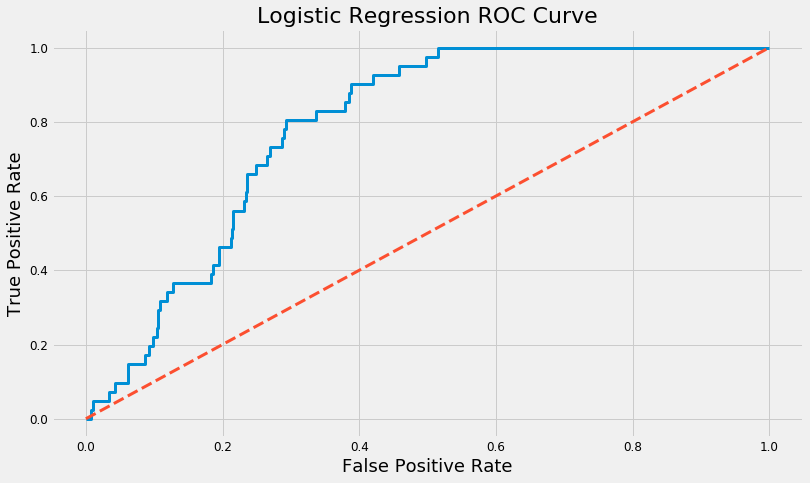

In [61]:
plt.plot(log_fpr, log_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve');

#### Area Under the Curve (AUC) Score

In [62]:
roc_auc_score(y_test, log_predict_proba)

0.7865100873230955

**Notes**  
Model performance appears to be pretty good based on the AUC. However, this is due to the high class imbalance in the dataset. This is not the best evaluation metric for this analysis.

#### Precision-Recall

In [63]:
# create precision recall curve data
# returns precision, recall for range of thresholds
log_pre, log_rec, log_thresh = precision_recall_curve(y_test, log_predict_proba)

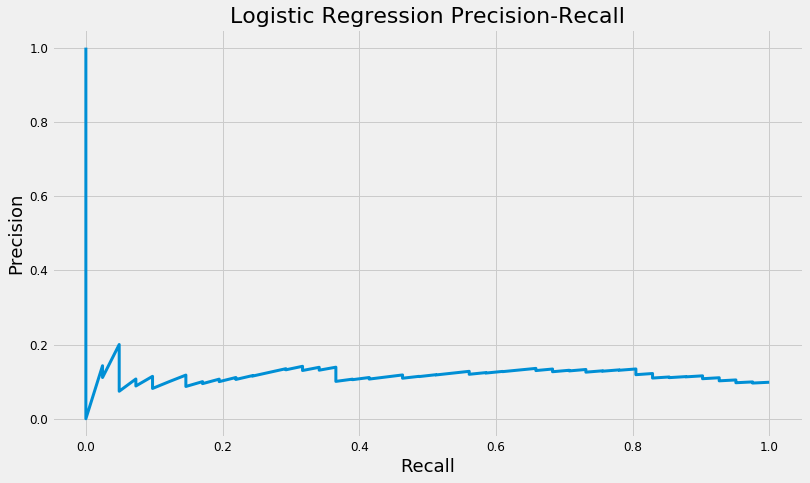

In [64]:
plt.plot(log_rec, log_pre)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression Precision-Recall');

#### Area Under the Curve (AUC) Score

In [65]:
auc(log_rec, log_pre)

0.11590327717655888

**Notes**  
The precision-recall curve gives a better representation of model performance.

# Random Forest Modeling

In [66]:
# dictionary to record model results
rf_recalls = {}

## Initial Model

In [67]:
rf = RandomForestClassifier(random_state=0) # note scaling not required

In [68]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [69]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
metrics.confusion_matrix(y_test, rf_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**
- model does not accurately predict many swing counties  
    - this is a result of the severe imbalance of classes in the dataset
- recall is to be prioritized
    - this will help the model capture more swing counties (label 1)
    - may result in more false positives and reduced overall accuracy

## Tuning with RandomizedSearch
Tune model hyperparameter for optimal model performance

In [71]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [72]:
hyperparams = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [73]:
# tune model pipeline for recall
rf_tune = RandomizedSearchCV(RandomForestClassifier(random_state=0), hyperparams, 
                           scoring='recall', cv=5, random_state=0)

In [74]:
rf_tune.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='recall', verbose=0

In [75]:
rf_pred = rf_tune.predict(X_test)

In [76]:
# record model recall results
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, rf_pred)
rf_recalls['initial'] = recall[1]

In [77]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.93      0.91       770



In [78]:
metrics.confusion_matrix(y_test, rf_pred)

array([[719,  10],
       [ 41,   0]])

In [79]:
# assign best hyperparameter values from tuning
best_n_estimators = rf_tune.best_params_['n_estimators']
best_max_features = rf_tune.best_params_['max_features']
best_max_depth = rf_tune.best_params_['max_depth']
best_min_samples_split = rf_tune.best_params_['min_samples_split']
best_min_samples_leaf = rf_tune.best_params_['min_samples_leaf']
best_bootstrap = rf_tune.best_params_['bootstrap']

**Notes**  
Tuning produces no significant improvement in model

## Balanced Weights
Modifies "weights" of classes in algorithm's cost function to place greater importance on minority class  
Balanced weights are inversely proportional to the frequency of class observations

In [80]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced')

In [81]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [82]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
metrics.confusion_matrix(y_test, rf_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**  
Balanced weights shows no improvement

In [84]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [85]:
hyperparams = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_tune = RandomizedSearchCV(rf, hyperparams, scoring='recall', cv=5, random_state=0)
rf_tune.fit(X_train, y_train)
rf_pred = rf_tune.predict(X_test)

In [86]:
# record model recall results
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, rf_pred)
rf_recalls['balanced'] = recall[1]

In [87]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       729
          1       0.22      0.20      0.21        41

avg / total       0.92      0.92      0.92       770



In [88]:
metrics.confusion_matrix(y_test, rf_pred)

array([[701,  28],
       [ 33,   8]])

**Notes**  
Model performance increased with tuning

In [89]:
best_n_estimators_bal = rf_tune.best_params_['n_estimators']
best_max_features_bal = rf_tune.best_params_['max_features']
best_max_depth_bal = rf_tune.best_params_['max_depth']
best_min_samples_split_bal = rf_tune.best_params_['min_samples_split']
best_min_samples_leaf_bal = rf_tune.best_params_['min_samples_leaf']
best_bootstrap_bal = rf_tune.best_params_['bootstrap']

## Synthetic Minority Over-sampling Technique (SMOTE)
Oversampling method that generates synthetic samples of the minority class

In [90]:
# model pipeline with SMOTE applied
rf_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('model', RandomForestClassifier(random_state=0))    
])

In [91]:
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

In [92]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.94      0.95       729
          1       0.21      0.29      0.24        41

avg / total       0.92      0.90      0.91       770



In [93]:
metrics.confusion_matrix(y_test, rf_pred)

array([[684,  45],
       [ 29,  12]])

**Notes**  
Some increased recall is observed for label 1 classification compared with initial model  
Try tuning this model

In [94]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [95]:
hyperparams = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf,
    'model__bootstrap': bootstrap
}

rf_tune = RandomizedSearchCV(rf_pipe, hyperparams, scoring='recall', cv=5, random_state=0)
rf_tune.fit(X_train, y_train)
rf_pred = rf_tune.predict(X_test)

In [96]:
# record model recall results
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, rf_pred)
rf_recalls['smote'] = recall[1]

In [97]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       729
          1       0.17      0.34      0.23        41

avg / total       0.92      0.88      0.90       770



In [98]:
metrics.confusion_matrix(y_test, rf_pred)

array([[662,  67],
       [ 27,  14]])

In [99]:
best_n_estimators_smt = rf_tune.best_params_['model__n_estimators']
best_max_features_smt = rf_tune.best_params_['model__max_features']
best_max_depth_smt = rf_tune.best_params_['model__max_depth']
best_min_samples_split_smt = rf_tune.best_params_['model__min_samples_split']
best_min_samples_leaf_smt = rf_tune.best_params_['model__min_samples_leaf']
best_bootstrap_smt = rf_tune.best_params_['model__bootstrap']

**Notes**  
Tuning has increased swing recall

## Final Model
Tuned model with SMOTE

In [100]:
rf_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('model', RandomForestClassifier(random_state=0,
                                     n_estimators=best_n_estimators_smt,
                                     max_features=best_max_features_smt,
                                     max_depth=best_max_depth_smt,
                                     min_samples_split=best_min_samples_split_smt,
                                     min_samples_leaf=best_min_samples_leaf_smt,
                                     bootstrap=best_bootstrap_smt)
    )
])

In [101]:
rf_pipe.fit(X_train, y_train)
rf_predict = rf_pipe.predict(X_test)

In [102]:
# save model
# filename = 'model_output/rf.sav'
# joblib.dump(rf_pipe, filename)

In [103]:
# load saved model
# rf_pipe = joblib.load('model_output/rf.sav')

### Evaluation

In [104]:
print(metrics.classification_report(y_test, rf_predict))

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       729
          1       0.17      0.34      0.23        41

avg / total       0.92      0.88      0.90       770



In [105]:
metrics.confusion_matrix(y_test, rf_predict)

array([[662,  67],
       [ 27,  14]])

In [106]:
# probabilities of swing county for each observation
rf_predict_proba = rf_pipe.predict_proba(X_test)[:, 1]

#### Receiver Operating Characteristic (ROC)

In [107]:
# create ROC curve data
# returns false positive rate, true positive rate for range of thresholds
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test, rf_predict_proba)

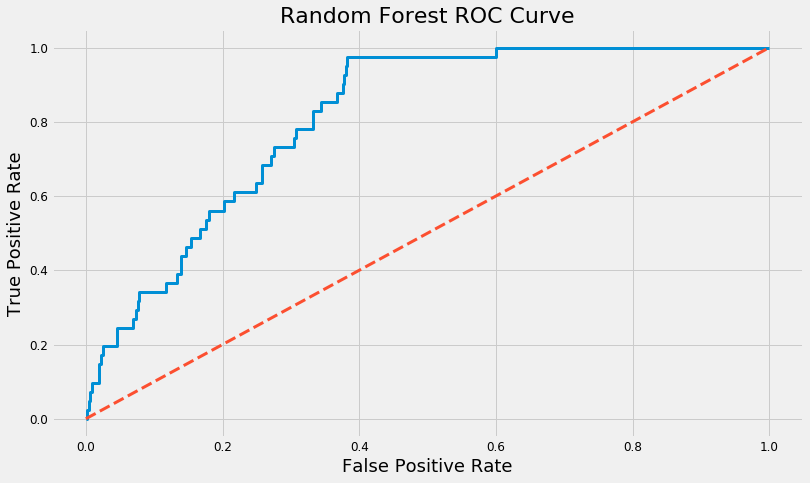

In [108]:
plt.plot(rf_fpr, rf_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve');

#### Area Under the Curve (AUC) Score

In [109]:
roc_auc_score(y_test, rf_predict_proba)

0.8127070159590485

**Notes**  
Model performance appears to be pretty good based on the AUC. However, this is due to the high class imbalance in the dataset. This is not the best evaluation metric for this analysis.

#### Precision-Recall

In [110]:
# create precision recall curve data
# returns precision, recall for range of thresholds
rf_pre, rf_rec, rf_thresh = precision_recall_curve(y_test, rf_predict_proba)

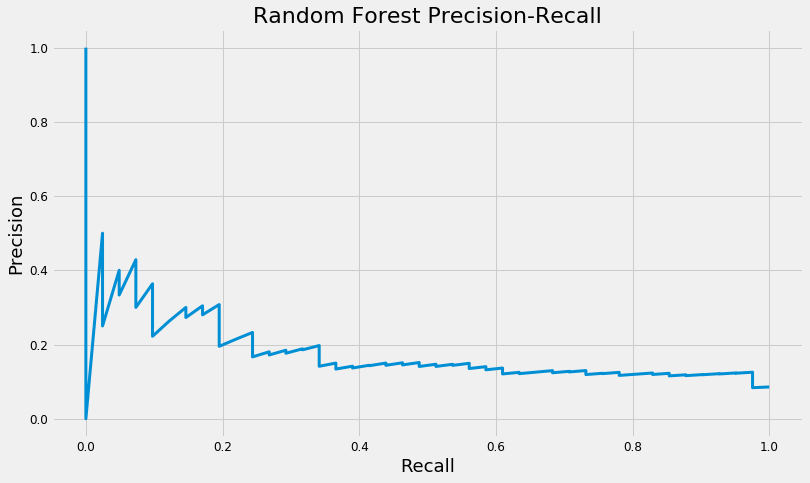

In [111]:
plt.plot(rf_rec, rf_pre)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall');

#### Area Under the Curve (AUC) Score

In [112]:
auc(rf_rec, rf_pre)

0.17166758692210235

**Notes**  
The precision-recall curve gives a better representation of model performance.

# Model Comparison

## Recall

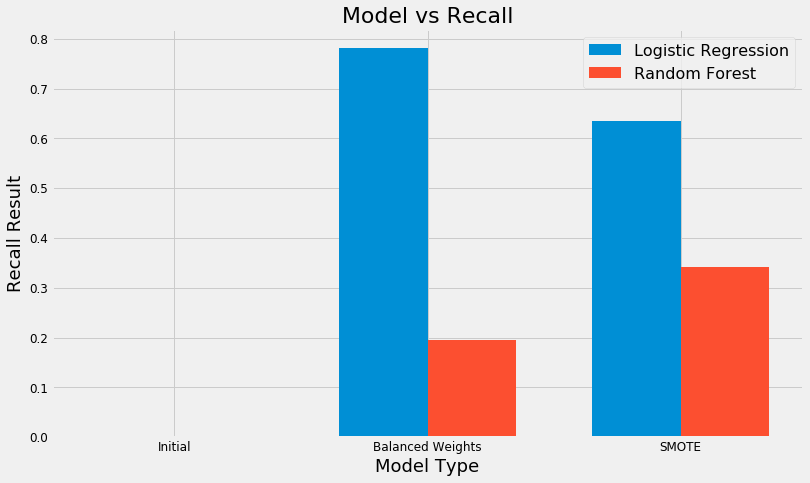

In [114]:
index = np.arange(len(log_recalls))
bar_width = 0.35

plt.bar(index, log_recalls.values(), width=bar_width, label='Logistic Regression')
plt.bar(index + bar_width, rf_recalls.values(), width=bar_width, label='Random Forest')
plt.title('Model vs Recall')
plt.xlabel('Model Type')
plt.ylabel('Recall Result')
plt.legend()
plt.xticks(index + bar_width/2, ['Initial', 'Balanced Weights', 'SMOTE']);
# plt.savefig('model_output/recall.png')

In [115]:
log_precision, log_recall, log_fscore, log_support = metrics.precision_recall_fscore_support(y_test, log_predict)
rf_precision, rf_recall, rf_fscore, rf_support = metrics.precision_recall_fscore_support(y_test, rf_predict)

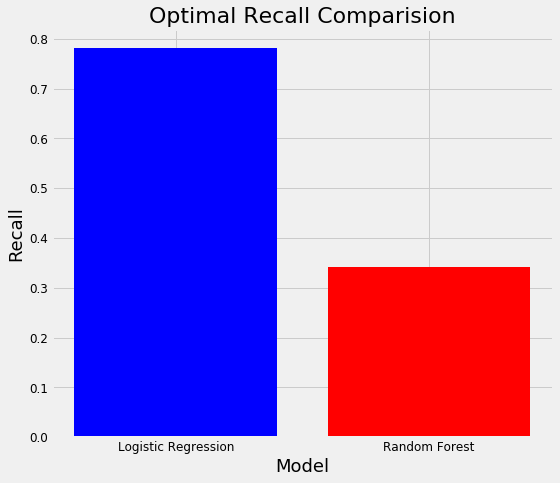

In [116]:
plt.figure(figsize=(8, 7))
plt.bar(range(2), [log_recall[1], rf_recall[1]], color=['b', 'r'])
plt.xticks(range(2), ['Logistic Regression', 'Random Forest'])
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Optimal Recall Comparision');
# plt.savefig('model_output/brecall.png')

**Notes**  
LR model has significantly better recall for identifying swing counties

## ROC

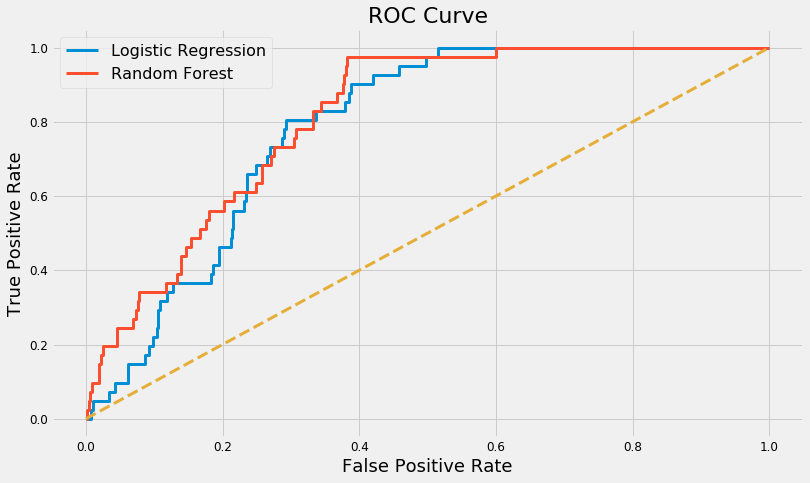

In [117]:
fig, ax = plt.subplots()
ax.plot(log_fpr, log_tpr, label='Logistic Regression')
ax.plot(rf_fpr, rf_tpr, label='Random Forest')
ax.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend();
# plt.savefig('model_output/roc.png')

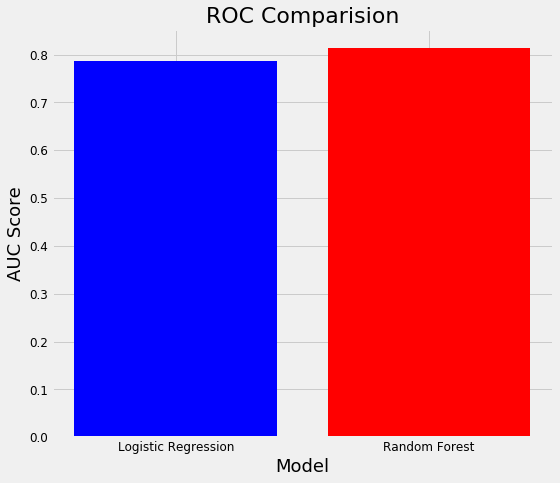

In [118]:
auc_scores = [roc_auc_score(y_test, log_predict_proba), roc_auc_score(y_test, rf_predict_proba)]
plt.figure(figsize=(8, 7))
plt.bar(range(2), auc_scores, color=['b', 'r'])
plt.xticks(range(2), ['Logistic Regression', 'Random Forest'])
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('ROC Comparision');

**Notes**  
RF has a slightly better ROC score

## Precision-Recall

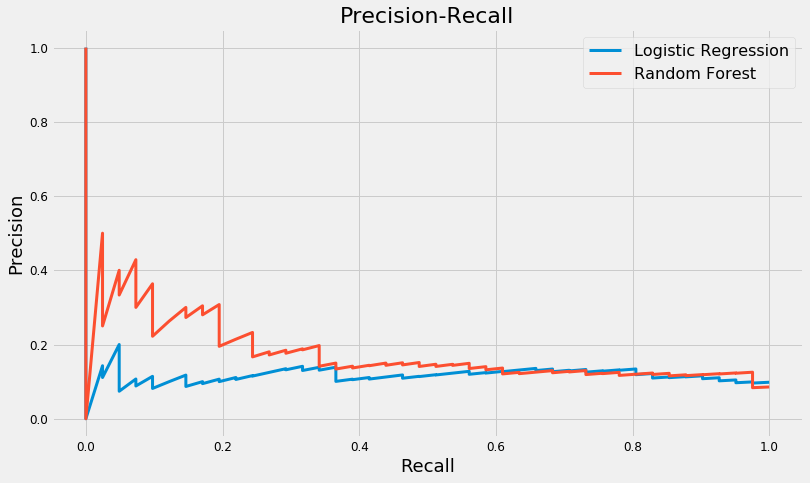

In [119]:
fig, ax = plt.subplots()
ax.plot(log_rec, log_pre, label='Logistic Regression')
ax.plot(rf_rec, rf_pre, label='Random Forest')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall')
ax.legend();
# plt.savefig('model_output/pre_rec.png')

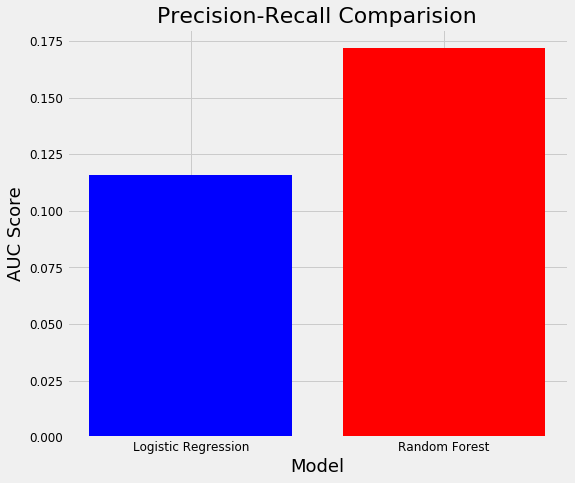

In [120]:
auc_scores = [auc(log_rec, log_pre), auc(rf_rec, rf_pre)]
plt.figure(figsize=(8, 7))
plt.bar(range(2), auc_scores, color=['b', 'r'])
plt.xticks(range(2), ['Logistic Regression', 'Random Forest'])
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Precision-Recall Comparision');

**Notes**  
RF has significantly better performance with precision-recall

# Final Analysis  
Priority for project is identifying as many swing counties as possible
- Logistic Regression model selected based on this metric

In [77]:
# load saved model
# log_pipe = joblib.load('model_output/log_reg.sav')
log_predict = log_pipe.predict(X_test)

## Confusion Matrix

In [78]:
metrics.confusion_matrix(y_test, log_predict)

array([[516, 213],
       [  9,  32]])

In [79]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, log_predict))
df_cm

,0,1
0,516,213
1,9,32


In [80]:
# normalize by class totals
df_cm = round(df_cm.div(df_cm.sum(axis=1), axis='rows')*100, 0)
df_cm

,0,1
0,71.0,29.0
1,22.0,78.0


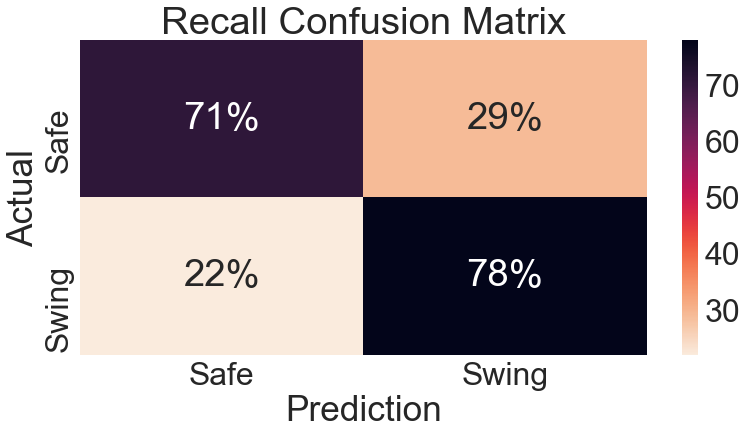

In [82]:
sns.set(font_scale=3.2)
sns_ax = sns.heatmap(df_cm, annot=True, cmap=sns.cm.rocket_r)
sns_ax.set(title='Recall Confusion Matrix', 
           xticklabels=(['Safe', 'Swing']), yticklabels=(['Safe', 'Swing']),
           xlabel='Prediction', ylabel='Actual'
          )
for t in sns_ax.texts: t.set_text(t.get_text() + "%");
# plt.tight_layout()
# plt.savefig('model_output/conf_mat.png')

## Threshold Modification
Modify decision threshold to capture more of the positive class

In [66]:
# lower probability threshold
threshold = 0.39
log_thresh_predict = log_predict_proba >= threshold

In [67]:
print(metrics.classification_report(y_test, log_thresh_predict))

             precision    recall  f1-score   support

          0       1.00      0.46      0.63       729
          1       0.09      1.00      0.17        41

avg / total       0.95      0.49      0.61       770



In [68]:
metrics.confusion_matrix(y_test, log_thresh_predict)

array([[337, 392],
       [  0,  41]])

In [69]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, log_thresh_predict))
df_cm

,0,1
0,337,392
1,0,41


In [70]:
# normalize by class totals
df_cm = round(df_cm.div(df_cm.sum(axis=1), axis='rows')*100, 0)
df_cm

,0,1
0,46.0,54.0
1,0.0,100.0


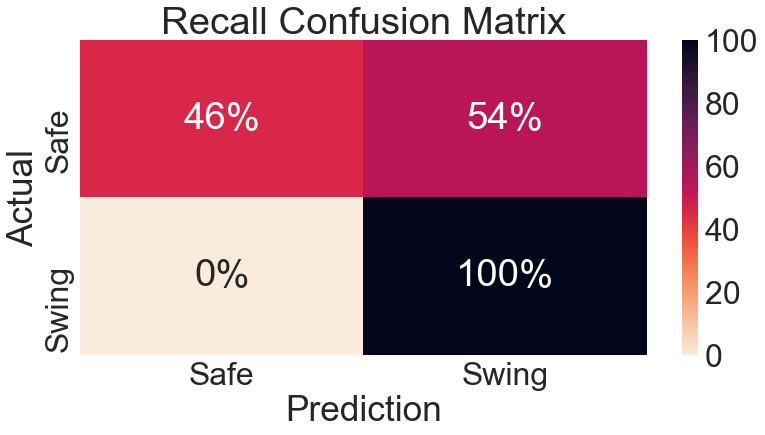

In [76]:
sns.set(font_scale=3.2)
sns_ax = sns.heatmap(df_cm, annot=True, cmap=sns.cm.rocket_r, fmt='g')
sns_ax.set(title='Recall Confusion Matrix', 
           xticklabels=(['Safe', 'Swing']), yticklabels=(['Safe', 'Swing']),
           xlabel='Prediction', ylabel='Actual'
          )
for t in sns_ax.texts: t.set_text(t.get_text() + "%");
# plt.tight_layout()
# plt.savefig('model_output/thr_conf_mat.png')

**Notes**  
Model is able to identify all swing counties when threshold is lowered to 0.39

## Logistic Regression Feature Interpretation
Analyze features given highest weight in LR model

In [124]:
log_coef = feat_sort(log_pipe.named_steps['model'].coef_[0], X_train.columns)
log_coef

,feat_wgt,positive
college_rate,0.676986,True
white_rate,0.393613,False
per_cap_income,0.003926,False
median_age,0.003361,False


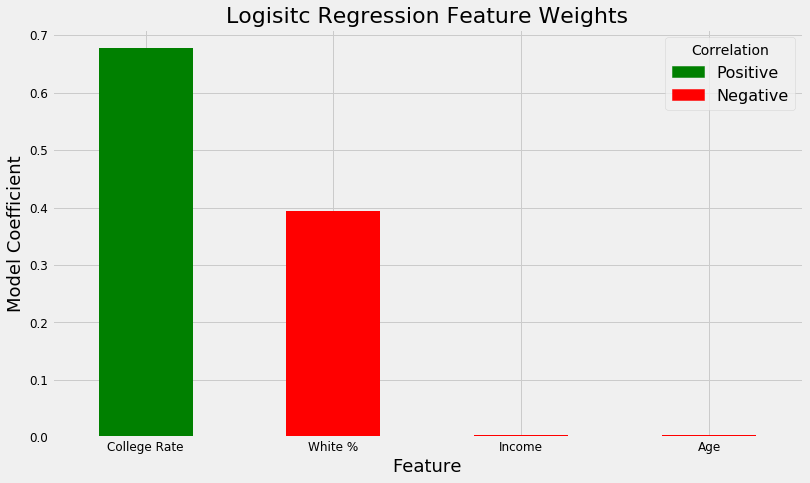

In [125]:
ax = plt.gca()
log_coef.iloc[:, 0].plot(kind='bar', ax=ax, color=log_coef.iloc[:, 1].map({True: 'g', False: 'r'}))
ax.set_title('Logisitc Regression Feature Weights')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Coefficient')
ax.set_xticklabels(['College Rate', 'White %', 'Income', 'Age'], rotation=0)

pos_patch = mpatches.Patch(color='green', label='Positive')
neg_patch = mpatches.Patch(color='red', label='Negative')
plt.legend(title='Correlation', handles=[pos_patch, neg_patch]);
# plt.savefig('model_output/lr_feat.png')

**Notes**  
- LR model has a strong, positive correlation with a county's college rate
- LR model has a strong, negative correlation with a county's white population rate
- LR model has a small, negative correlation with a county's average income and average age
- LR model dropped all other features, indicating no or low importance on swing county prediction

## Random Forest Feature Interpretation
For comparison, analyze features given high importanc in RF model

In [126]:
rf_imp = feat_sort(rf_pipe.named_steps['model'].feature_importances_, X_train.columns)
rf_imp

,feat_wgt,positive
college_rate,0.279538,True
white_rate,0.202808,True
density,0.068064,True
households,0.061268,True
population,0.058695,True
per_cap_income,0.052871,True
hh_income,0.048652,True
hisp_rate,0.047634,True
growth,0.041947,True
poverty_rate,0.038594,True


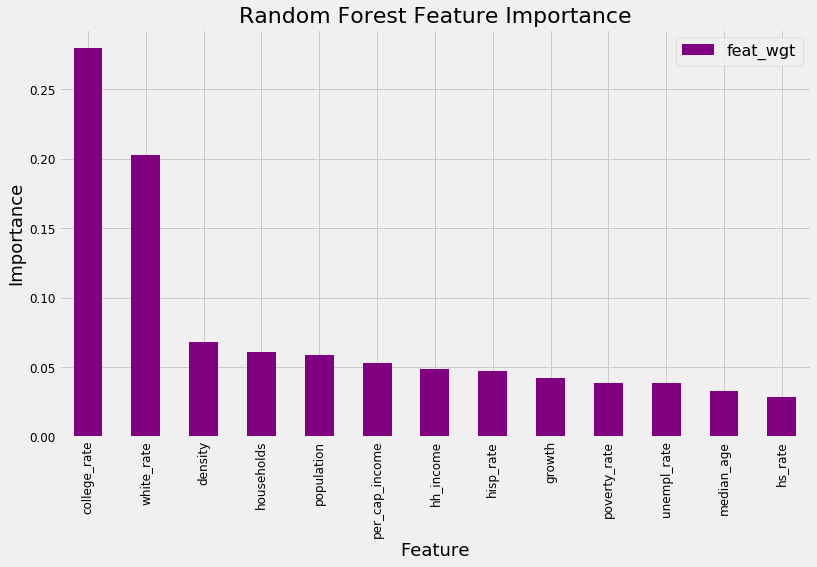

In [127]:
ax = plt.gca()
rf_imp.plot(kind='bar', ax=ax, color='purple')
ax.set_title('Random Forest Feature Importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance');

**Notes**  
- RF model has strong correlation with a county's college rate and white population rate
- RF model has much smaller correlation with all other county features

## Averages of Classes
Compare model feature weights against a simple difference of feature averages between classes

In [128]:
cls_feat = df.groupby('close_elect').mean().copy()
cls_feat

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,97754.622861,0.673854,35383.793292,41.180151,40647.942847,49173.193018,4.611328,15.914203,85.657392,20.269884,251.164202,0.838362,0.088684
1,213686.159236,2.568153,77334.891720,38.888535,42207.388535,53773.019108,4.530573,15.549045,88.495541,27.620382,317.779807,0.760183,0.095176


In [129]:
cls_feat.sum()

population        311440.782097
growth                 3.242006
households        112718.685012
median_age            80.068686
per_cap_income     82855.331382
hh_income         102946.212127
unempl_rate            9.141901
poverty_rate          31.463247
hs_rate              174.152934
college_rate          47.890266
density              568.944008
white_rate             1.598546
hisp_rate              0.183860
dtype: float64

In [130]:
cls_feat.div(cls_feat.sum())

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,0.313879,0.207851,0.313912,0.51431,0.490589,0.477659,0.504417,0.505803,0.491852,0.423257,0.441457,0.524453,0.482346
1,0.686121,0.792149,0.686088,0.48569,0.509411,0.522341,0.495583,0.494197,0.508148,0.576743,0.558543,0.475547,0.517654


In [131]:
cls_feat.div(cls_feat.sum()).diff()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.372243,0.584298,0.372175,-0.028621,0.018821,0.044682,-0.008833,-0.011606,0.016297,0.153486,0.117086,-0.048906,0.035309


In [132]:
cls_feat.div(cls_feat.sum()).diff().iloc[1, :]

population        0.372243
growth            0.584298
households        0.372175
median_age       -0.028621
per_cap_income    0.018821
hh_income         0.044682
unempl_rate      -0.008833
poverty_rate     -0.011606
hs_rate           0.016297
college_rate      0.153486
density           0.117086
white_rate       -0.048906
hisp_rate         0.035309
Name: 1, dtype: float64

In [133]:
cls_avg = feat_sort(cls_feat.div(cls_feat.sum()).diff().iloc[1, :].values, X_train.columns)
cls_avg

,feat_wgt,positive
growth,0.584298,True
population,0.372243,True
households,0.372175,True
college_rate,0.153486,True
density,0.117086,True
white_rate,0.048906,False
hh_income,0.044682,True
hisp_rate,0.035309,True
median_age,0.028621,False
per_cap_income,0.018821,True


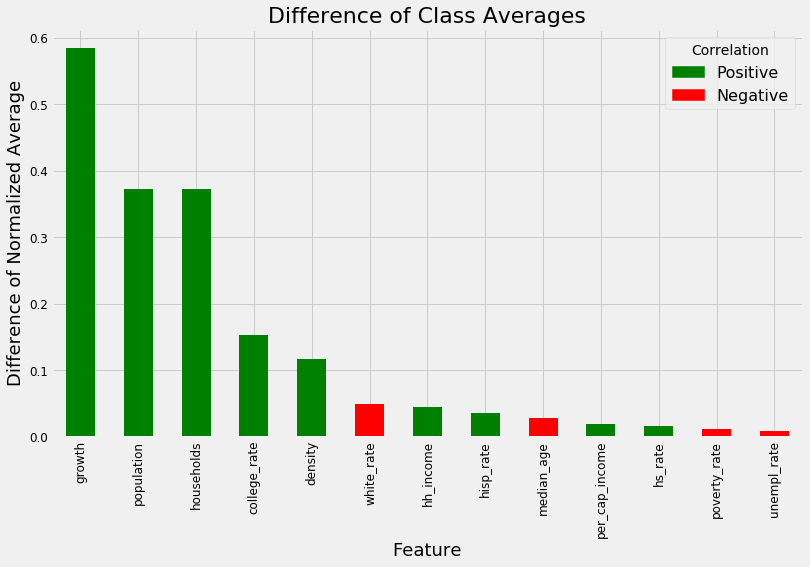

In [134]:
ax = plt.gca()
cls_avg.iloc[:, 0].plot(kind='bar', ax=ax, color=cls_avg.iloc[:, 1].map({True: 'g', False: 'r'}))
ax.set_title('Difference of Class Averages')
ax.set_xlabel('Feature')
ax.set_ylabel('Difference of Normalized Average')
ax.set_xticklabels(cls_avg.index)

pos_patch = mpatches.Patch(color='green', label='Positive')
neg_patch = mpatches.Patch(color='red', label='Negative')
plt.legend(title='Correlation', handles=[pos_patch, neg_patch]);

**Notes**  
- Plot shows strong, positive correlation with a county's growth rate, population and number of households
- College rate correlation is smaller and positive
- White population rate correlation is small and negative

# Example Counties

## PCA

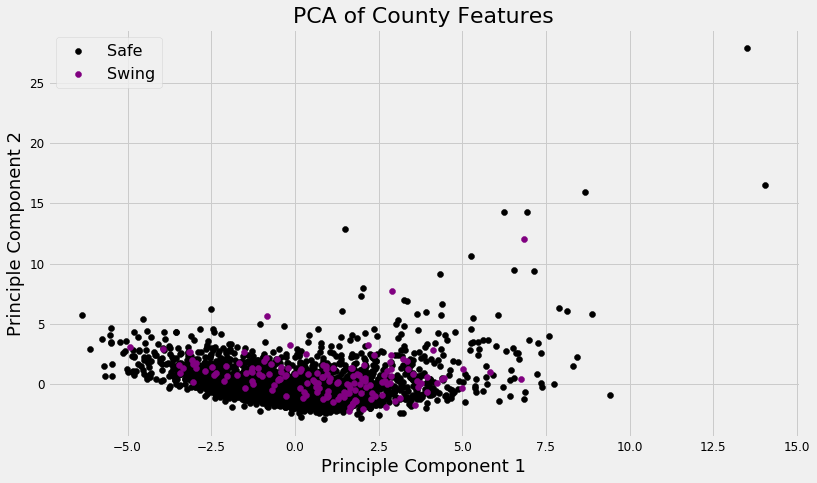

In [135]:
# plot components
class_labels = ['Safe', 'Swing']
colors = ['black', 'purple']

plt.figure()
for i, label in enumerate(class_labels):
    plt.scatter(pca_features[y == i, 0], pca_features[y == i, 1],
                label=label, c=colors[i])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('PCA of County Features')
plt.legend();

In [136]:
# target "typical" swing counties in pca plot

# principle component 1 range
comp1_min = 0
comp1_max = 2.5
# principle component 2 range
comp2_min = -2.5
comp2_max = 2.5

In [137]:
df_pca = pd.DataFrame(pca_features, index=df.index)

In [138]:
pca_conditions = (df_pca.iloc[:, 0] >= comp1_min) & (df_pca.iloc[:, 0] <= comp1_max) \
                  & (df_pca.iloc[:, 1] >= comp2_min) & (df_pca.iloc[:, 1] <= comp2_max)

### "Safe" Counties

In [139]:
df_safe = df_pca.loc[pca_conditions & (y == 0), :].index

In [140]:
df.loc[df_safe, :].mean()

population        70491.070461
growth                1.800903
households        26441.289973
median_age           41.696296
per_cap_income    44274.339657
hh_income         54136.475158
unempl_rate           3.765221
poverty_rate         11.979584
hs_rate              89.700813
college_rate         22.887353
density             122.339761
white_rate            0.893603
hisp_rate             0.068613
close_elect           0.000000
dtype: float64

In [141]:
safe = df_safe[(df.loc[df_safe, :]['college_rate'] > 20) \
               & (df.loc[df_safe, :]['college_rate'] < 21) & (df.loc[df_safe, :]['population'] > 100000)]

### Outliers

In [142]:
outliers = []

In [143]:
# find index of max principle component 2
df_pca.loc[:, 1].idxmax()

6037

In [144]:
# coordinate in pca
df_pca.loc[df_pca.loc[:, 1].idxmax(), :]

0    13.519364
1    27.906877
Name: 6037, dtype: float64

In [145]:
# add to example county list
outliers.append(df_pca.loc[:, 1].idxmax())

In [146]:
# max principle component 1
outliers.append(df_pca.loc[:, 0].idxmax())

In [147]:
# min principle component 1
outliers.append(df_pca.loc[:, 0].idxmin())

### "Swing" Counties

In [148]:
df_swing = df_pca.loc[pca_conditions & (y == 1), :].index

In [149]:
df.loc[df_swing, :].mean()

population        143607.898551
growth                 2.566667
households         55356.811594
median_age            39.734783
per_cap_income     43028.420290
hh_income          54890.594203
unempl_rate            4.166667
poverty_rate          13.395652
hs_rate               90.928986
college_rate          29.482609
density              253.702512
white_rate             0.863252
hisp_rate              0.075724
close_elect            1.000000
dtype: float64

In [150]:
swing = df_swing[(df.loc[df_swing, :]['college_rate'] > 29) & (df.loc[df_swing, :]['college_rate'] < 30)]

## County Location and Features

In [151]:
# read in county code data
df_county = pd.read_csv('data/us_county_codes.csv')
df_county.set_index('FIPS ', inplace=True)
df_county.head()

,Name,State
FIPS,,
1001,Autauga,AL
1003,Baldwin,AL
1005,Barbour,AL
1007,Bibb,AL
1009,Blount,AL


In [152]:
# merge county feature data and county code data on county code (indicies)
df_feat_cty = pd.merge(df, df_county, left_index=True, right_index=True)
df_feat_cty.head()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect,Name,State
1001,55504.0,1.7,20800.0,37.8,39721.0,54487.0,3.9,13.5,87.6,24.6,93.371913,0.762305,0.025512,0,Autauga,AL
1003,212628.0,16.7,75149.0,42.3,41286.0,56460.0,4.0,11.7,90.0,29.5,133.746808,0.810999,0.040973,0,Baldwin,AL
1005,25270.0,-8.0,9122.0,38.7,31788.0,32884.0,5.9,29.9,73.8,12.9,28.557545,0.491888,0.045390,0,Barbour,AL
1007,22668.0,-1.1,7048.0,40.2,29264.0,43079.0,4.4,20.1,80.7,12.0,36.409779,0.766278,0.022146,0,Bibb,AL
1009,58013.0,1.2,20619.0,40.8,31470.0,47213.0,4.0,14.1,80.0,13.0,89.973324,0.949322,0.086808,0,Blount,AL


In [153]:
# example safe features
df_feat_cty.loc[safe, :]

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect,Name,State
code,,,,,,,,,,,,,,,,
2170,106532.0,19.7,30839.0,34.8,44880.0,71793.0,8.7,9.5,92.4,20.6,4.329179,0.775082,0.041894,0,Matanuska-Susitna,AK
6089,179921.0,1.5,69713.0,42.3,42411.0,46663.0,5.8,17.2,90.0,20.1,47.656142,0.866736,0.092835,0,Shasta,CA
18019,116973.0,6.1,43074.0,38.8,41026.0,51837.0,3.5,10.5,87.9,20.2,313.718286,0.859224,0.049866,0,Clark,IN
18089,485640.0,-2.1,184140.0,38.2,40628.0,53600.0,5.1,16.6,87.6,20.9,973.304473,0.623645,0.181906,0,Lake,IN
22019,202445.0,5.0,76270.0,36.1,44743.0,47052.0,3.9,19.9,85.4,20.6,190.328676,0.688982,0.029549,0,Calcasieu,LA
23001,107651.0,0.0,44747.0,40.7,38091.0,48494.0,3.1,12.7,89.4,20.7,230.057915,0.920279,0.017287,0,Androscoggin,ME
24043,150578.0,2.1,56094.0,40.7,43470.0,54643.0,4.6,13.2,86.9,20.1,328.930928,0.829490,0.041726,0,Washington,MD
26075,158640.0,-1.0,60803.0,40.8,38331.0,50809.0,4.7,13.6,89.8,20.6,226.089187,0.879343,0.033453,0,Jackson,MI
42055,154234.0,3.1,59392.0,40.9,42275.0,59474.0,4.5,9.1,86.5,20.1,199.728057,0.921321,0.050080,0,Franklin,PA


In [154]:
safe_ex = [6037, 36061, 18019, 42055, 55105]

In [155]:
df_county.loc[safe_ex, :]

,Name,State
FIPS,,
6037,Los Angeles,CA
36061,New York,NY
18019,Clark,IN
42055,Franklin,PA
55105,Rock,WI


In [156]:
# example swing features
df_feat_cty.loc[swing, :]

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect,Name,State
code,,,,,,,,,,,,,,,,
17143,183011.0,-1.9,75406.0,36.9,47673.0,52380.0,5.8,15.2,90.3,29.8,295.555627,0.750649,0.045658,1,Peoria,IL
19061,97041.0,3.6,38006.0,38.5,45068.0,59403.0,3.0,10.5,92.3,29.2,159.528193,0.927185,0.021908,1,Dubuque,IA
20177,178187.0,0.1,71015.0,38.8,44504.0,55387.0,3.7,10.9,91.1,29.3,327.537591,0.829595,0.117309,1,Shawnee,KS
23027,39832.0,2.7,16820.0,45.4,37334.0,48422.0,3.6,14.3,91.9,29.2,54.570364,0.948710,0.011197,1,Waldo,ME
27169,50873.0,-1.1,19078.0,34.0,44354.0,56499.0,3.1,11.5,92.5,29.3,81.239520,0.944194,0.027520,1,Winona,MN
35043,142507.0,8.3,48534.0,39.4,38677.0,58621.0,6.2,14.5,90.8,29.7,38.404862,0.678472,0.361049,1,Sandoval,NM
36021,60604.0,-3.9,25295.0,47.0,50935.0,57579.0,3.8,12.7,88.9,29.5,95.482976,0.913851,0.044205,1,Columbia,NY
36083,159722.0,0.2,63553.0,39.8,45212.0,63174.0,4.5,11.6,91.3,29.3,244.810938,0.870350,0.044966,1,Rensselaer,NY
42043,275710.0,2.8,110211.0,39.6,47864.0,59958.0,4.5,11.3,89.1,29.3,525.111894,0.707983,0.081299,1,Dauphin,PA


In [157]:
swing_ex = [17143, 20177, 42043]

In [158]:
df_county.loc[swing_ex, :]

,Name,State
FIPS,,
17143,Peoria,IL
20177,Shawnee,KS
42043,Dauphin,PA
